# SPARC-4 Pipeline Tools
## Night:``2023-06-06``
## Modes: ``PHOTOMETRY`` and ``POLARIMETRY``
***

This notebook shows an example of the full reduction of the SPARC4 data  in the [minidata package](https://drive.google.com/file/d/1tAVjyhYGMDcrU5sDdGCmd_f5HoazZ294/view?usp=drive_link)  using the SPARC4 pipeline tools. 

* Author: Eder Martioli, LNA 18 Apr 2024

In [1]:
import os, sys
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.utils as s4utils
import glob
import warnings
warnings.filterwarnings('ignore')

## User inputs and initial setup

Before starting the reduction, we must configure a few parameters. The pipeline comes with default values for all parameters. To modify these, one can create and edit their own parameter file, then load it into the ``PARAMS_FILE`` variable. Alternatively, parameters can be changed by directly resetting the dictionary entry for a specific parameter, like this: ``p['PARAM_NAME'] = PARAM_NEW_VALUE``. See examples below.

In [2]:
# set night directory name
NIGHTDIR = '20230606'
# set raw data root directory
ROOTDATADIR =  "/Users/eder/Data/SPARC4/minidata/"
# set reduced data root directory
ROOTREDUCEDDIR = "/Users/eder/Data/SPARC4/minidata/reduced/"
# set reduced data root directory
PIPELINEDIR = "/Users/eder/sparc4-pipeline/"
# define path to default calibration directory
calibdb_dir = os.path.join(PIPELINEDIR, "calibdb/")

# set path to the parameters file:
#PARAMS_FILE = ""  # to use deafult values
PARAMS_FILE = "{}/user_files/my_params.yaml".format(PIPELINEDIR)

# set path to a target list file
# this is to force targets to be included in the source catalog in addition to those detected automatically
#TARGET_LIST_FILE = os.path.join(PIPELINEDIR,"user_files/targets.csv")

# select a SPARC4 channel: 1 (g), 2 (r), 3 (i) or 4 (z)
CHANNEL = 4

# initialize pipeline parameters
p = s4pipelib.init_s4_p(NIGHTDIR,
                        ROOTDATADIR,
                        ROOTREDUCEDDIR,
                        print_report=False,
                        param_file=PARAMS_FILE)

# get data dir
datadir = p['data_directories'][CHANNEL-1]
# get reduce dir
reducedir = p['reduce_directories'][CHANNEL-1]

# to force reduction even if products already exist
FORCE = False

###############################################################
# Below are a few examples on how to manually reset parameters: 
###############################################################

# set astrometry reference image as the one for this channel
p["ASTROM_REF_IMG"] = os.path.join(calibdb_dir, p["ASTROM_REF_IMGS"][CHANNEL-1])

# to build stacks of 10 images instead of the default value of 16 images
p['NFILES_FOR_STACK'] = 10

# to change the S/N threshold for detecting sources
# -- note that lower values will result in more (fainter) sources being detected.
p['PHOT_THRESHOLD'] = 100

# uncomment below to print all parameters and their respective values:
#for key in p.keys():
#    print("p['{}']={}".format(key,p[key]))

***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

In this section we build the master bias and flat-field calibrations.

## Define input list and output product file names

In [3]:
# create a list of zeros for current detector mode
zero_list = glob.glob("{}/{}".format(datadir,"*zero*.fits"))

# define file name of master bias 
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# create a list of flats for current detector mode
flat_list = glob.glob("{}/{}".format(datadir,"*dflat*.fits"))

# define file name of master flat
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# Run master calibration

The master calibration routine combines a list of calibration files into a master calibration image.

In [4]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     force=FORCE)

bias files: 3
gain: 3.36 electron / adu
processing frame 1 of 3
processing frame 2 of 3
processing frame 3 of 3


2024-04-18 16:23:29,704 astropop - INFO - Combining 3 images with median method.  [imcombine]


Normalization mean value: 1680.9159173583987 electron


In [5]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     normalize=True, 
                                     force=FORCE)

flat files: 3
gain: 3.36 electron / adu
processing frame 1 of 3
processing frame 2 of 3
processing frame 3 of 3


2024-04-18 16:23:30,547 astropop - INFO - Combining 3 images with median method.  [imcombine]


Normalization mean value: 56489.83415908813 electron


# Plot master calibration results

Now, we plot the results to check if they look fine. 

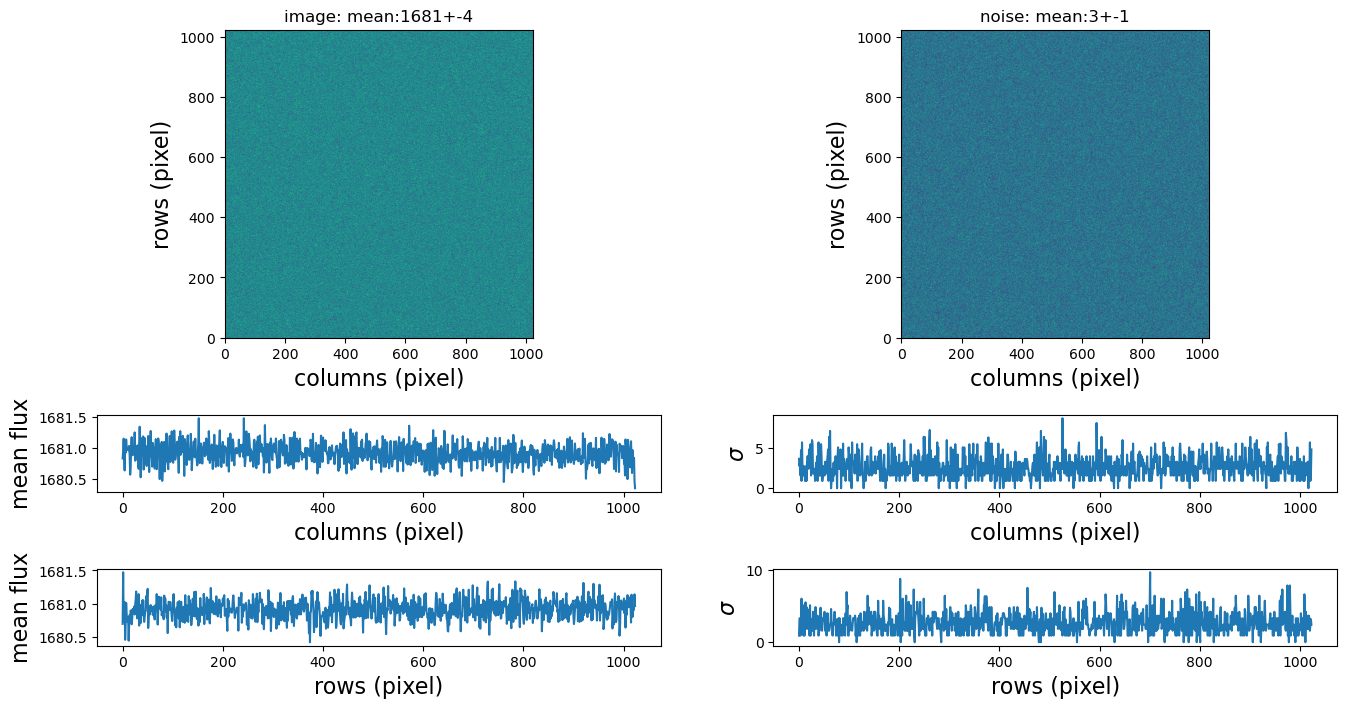

In [6]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

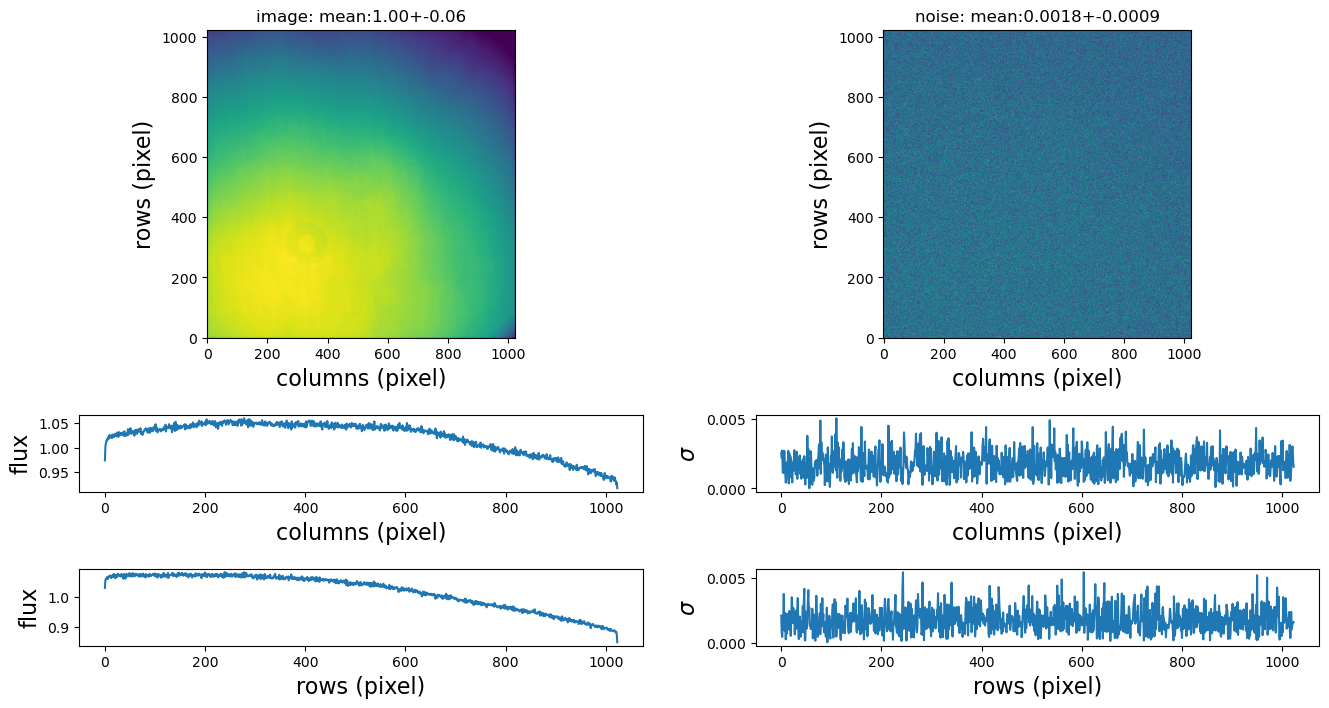

In [7]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)

***
# <font color='darkblue'>Science image reduction</font> 

In this section we reduce the science data. In this example we show the reductiion processes for the following observations:

* The photometric standard [LTT 4816](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=ltt4816&submit=SIMBAD+search) observed in photometric mode. 
* The polarimetric standard [HD 111579](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=HD+111579&submit=SIMBAD+search) observed in polarimetric mode.  It was observed in 16 rotating positions of the waveplate, equally spaced by 22.5 degrees, utilizing both L/2 and L/4 waveplate retarders.

## `PHOTOMETRIC` mode

### Select LTT 4816 data

In [8]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "ltt4816"  # LTT 4816 is a spectro-photometric standard

# set suffix for output stack filename
stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR, 
                                    CHANNEL, 
                                    OBJECTID.replace(" ",""))
# create a list of science data 
sci_list = glob.glob("{}/{}".format(datadir,"*ltt4816.fits"))

### Reduce LTT 4816 data

To reduce scientific frames, run the routine ``s4pipelib.stack_and_reduce_sci_images``. This routine performs calibration for detector gain, bias, and flat-field. Then, a subset of frames is stacked to generate a stack product. Source detection is then conducted within the stack frame, and the identified sources are cross-referenced with a catalog to establish an astrometric solution and generate a master catalog for all input observations of this field. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into ``proc.fits`` product FITS files.

0 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000013_ltt4816.fits
OBJECT files: 7
Loading science frames to memory ... 
gain: 3.36 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 7 : 20230606_s4c4_000013_ltt4816.fits 
Calibrating science frame 2 of 7 : 20230606_s4c4_000014_ltt4816.fits 
Calibrating science frame 3 of 7 : 20230606_s4c4_000015_ltt4816.fits 
Calibrating science frame 4 of 7 : 20230606_s4c4_000012_ltt4816.fits 
Calibrating science frame 5 of 7 : 20230606_s4c4_000009_ltt4816.fits 
Calibrating science frame 6 of 7 : 20230606_s4c4_000010_ltt4816.fits 
Calibrating science frame 7 of 7 : 20230606_s4c4_000011_ltt4816.fits 


2024-04-18 16:23:35,503 astropop - INFO - Registering image 1 from 7  [register]
2024-04-18 16:23:35,505 astropop - INFO - Images are equal, skipping registering.  [register]
2024-04-18 16:23:35,599 astropop - INFO - Registering image 2 from 7  [register]


Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000013_ltt4816.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000014_ltt4816.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000015_ltt4816.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000012_ltt4816.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000009_ltt4816.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000010_ltt4816.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000011_ltt4816.fits


2024-04-18 16:23:35,764 astropop - INFO - Filling registered image with cval=546.36  [register]
2024-04-18 16:23:35,766 astropop - INFO - Registering image with: translation=[0.75 0.25], rotation=0.00°  [register]
2024-04-18 16:23:35,996 astropop - INFO - Registering image 3 from 7  [register]
2024-04-18 16:23:36,100 astropop - INFO - Filling registered image with cval=548.78  [register]
2024-04-18 16:23:36,103 astropop - INFO - Registering image with: translation=[ 0.5  -0.25], rotation=0.00°  [register]
2024-04-18 16:23:36,353 astropop - INFO - Registering image 4 from 7  [register]
2024-04-18 16:23:36,501 astropop - INFO - Filling registered image with cval=547.44  [register]
2024-04-18 16:23:36,503 astropop - INFO - Registering image with: translation=[ 0.25 -0.  ], rotation=0.00°  [register]
2024-04-18 16:23:36,733 astropop - INFO - Registering image 5 from 7  [register]
2024-04-18 16:23:36,874 astropop - INFO - Filling registered image with cval=559.87  [register]
2024-04-18 16:2

Creating new catalog of detected sources:
Solving astrometry in PHOT-MODE using astrometry_from_existing_wcs()
Running photometry for multiple apertures:
Aperture radius of 6 pixels: 1 of 6 :
Aperture radius of 8 pixels: 2 of 6 :
Aperture radius of 10 pixels: 3 of 6 :
Aperture radius of 12 pixels: 4 of 6 :
Aperture radius of 14 pixels: 5 of 6 :
Aperture radius of 16 pixels: 6 of 6 :
The 7 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 7 ... 
OBJECT files: 7
Creating output list of processed science frames ... 
1 of 7 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000013_ltt4816_proc.fits
2 of 7 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000014_ltt4816_proc.fits
3 of 7 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000015_ltt4816_proc.fits
4 of 7 is reduced? False -> /Users/eder

2024-04-18 16:23:45,993 astropop - INFO - Computing shift of image 1 from 7  [register]
2024-04-18 16:23:45,994 astropop - INFO - Computing shift of image 2 from 7  [register]
2024-04-18 16:23:46,047 astropop - INFO - Computing shift of image 3 from 7  [register]
2024-04-18 16:23:46,129 astropop - INFO - Computing shift of image 4 from 7  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000013_ltt4816.fits


2024-04-18 16:23:46,214 astropop - INFO - Computing shift of image 5 from 7  [register]
2024-04-18 16:23:46,304 astropop - INFO - Computing shift of image 6 from 7  [register]
2024-04-18 16:23:46,393 astropop - INFO - Computing shift of image 7 from 7  [register]


Processing file: 20230606_s4c4_000013_ltt4816.fits
Running aperture photometry for catalogs with an offset of dx=0.0 dy=0.0
Saving frame 1 of 7: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000013_ltt4816.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000013_ltt4816_proc.fits
Processing file: 20230606_s4c4_000014_ltt4816.fits
Running aperture photometry for catalogs with an offset of dx=0.75 dy=0.25
Saving frame 2 of 7: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000014_ltt4816.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000014_ltt4816_proc.fits
Processing file: 20230606_s4c4_000015_ltt4816.fits
Running aperture photometry for catalogs with an offset of dx=0.5 dy=-0.25
Saving frame 3 of 7: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000015_ltt4816.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000015_

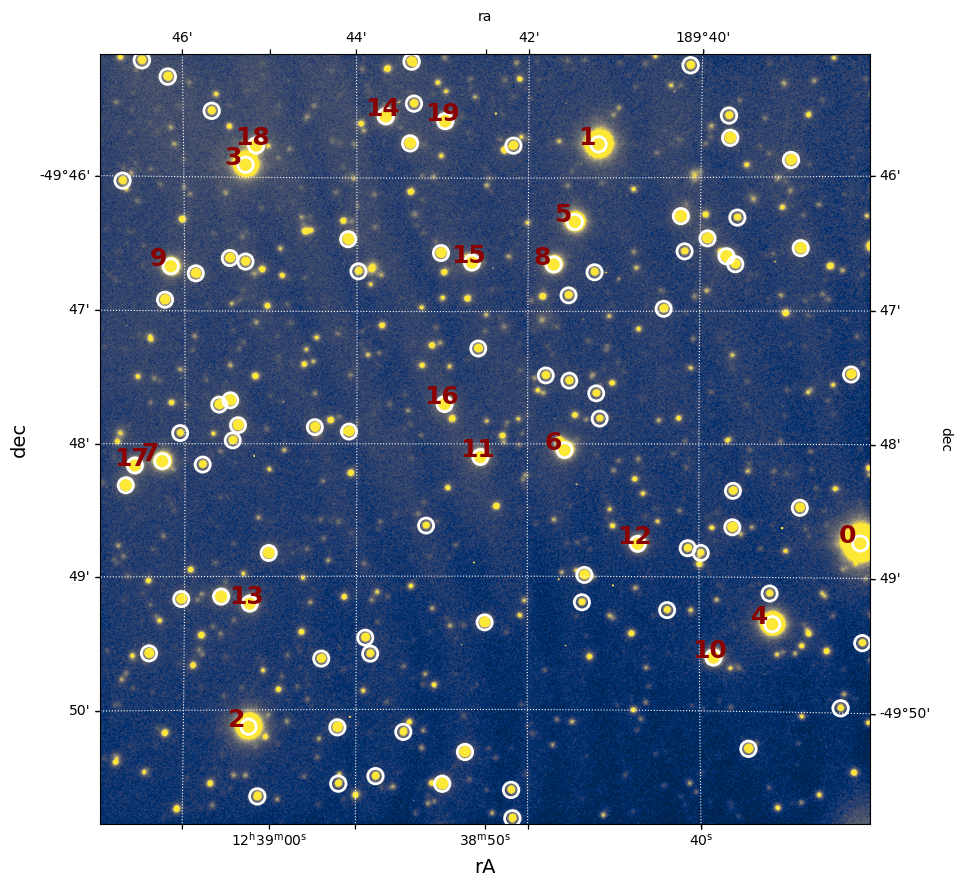

In [9]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          sci_list,
                                          reducedir,
                                          stack_suffix=stack_suffix,
                                          force=FORCE,
                                          verbose=True,
                                          plot=True) 

### PLOT results

The function ``s4plt.plot_sci_frame`` can be used to plot ``proc.fits`` or ``stack.fits`` products, as in the example below.  

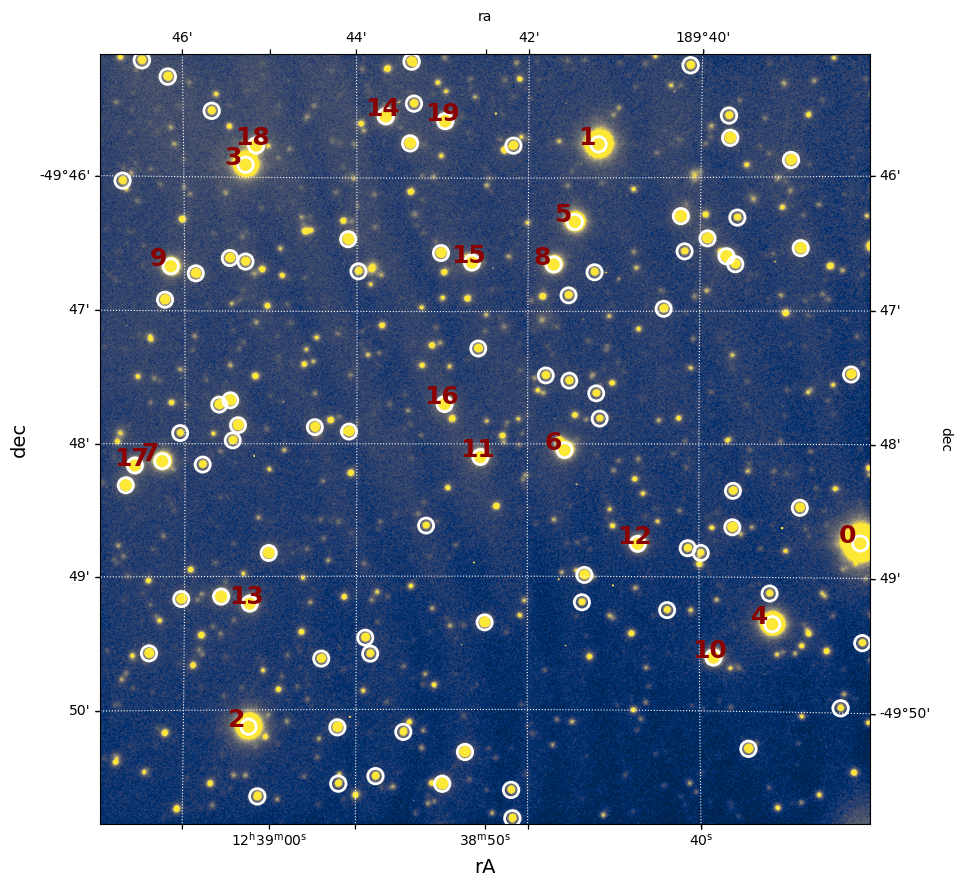

In [10]:
s4plt.plot_sci_frame(p['OBJECT_STACK'], cat_ext=3, nstars=20, use_sky_coords=True)

## Time series of `PHOTOMETRY` data : `light curve`

In this section, we compile all photometric information from the reduced ``proc.fits`` frames into a photometric time series product (`light curve`) using the routine ``s4pipelib.phot_time_series``. For this example, since there are only a few frames, the time series is not particularly interesting, as it contains only a few points in the time series.

In [11]:
ts_suffix = "{}_s4c{}_{}".format(NIGHTDIR, CHANNEL, OBJECTID.replace(" ",""))

list_of_catalogs = s4pipelib.get_list_of_catalogs(p['PHOT_APERTURES_FOR_LIGHTCURVES'])

phot_ts_product = s4pipelib.phot_time_series(p['OBJECT_REDUCED_IMAGES'][1:],
                                             ts_suffix=ts_suffix,
                                             reduce_dir=reducedir,
                                             time_key=p['TIME_KEYWORD_IN_PROC'],
                                             time_format=p['TIME_FORMAT_IN_PROC'],
                                             catalog_names=list_of_catalogs,
                                             time_span_for_rms=p['TIME_SPAN_FOR_RMS'],
                                             force=FORCE)

Packing time series data for catalog: CATALOG_PHOT_AP006
Packing time series data for catalog: CATALOG_PHOT_AP008
Packing time series data for catalog: CATALOG_PHOT_AP010
Packing time series data for catalog: CATALOG_PHOT_AP012
Packing time series data for catalog: CATALOG_PHOT_AP014
Packing time series data for catalog: CATALOG_PHOT_AP016


The function ``s4plt.plot_light_curve`` enables access to the photometric time series product and facilitates the construction of differential photometric light curves. The results are plotted and returned as an Astropy Table, which can also be saved to an output CSV file.

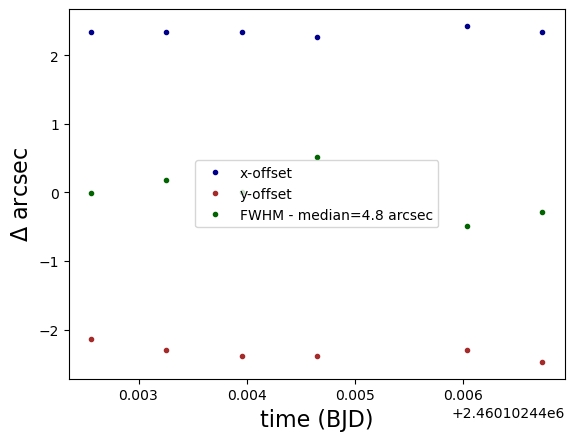

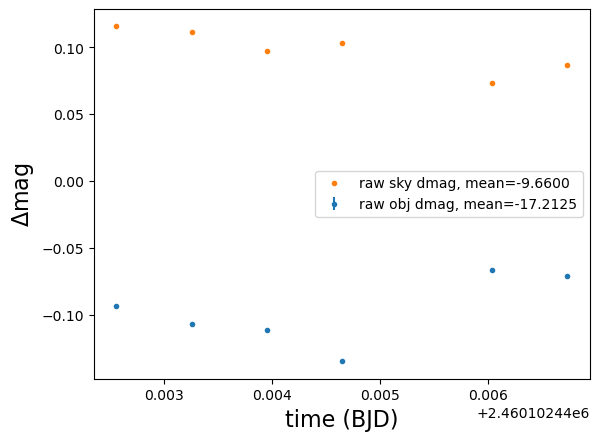

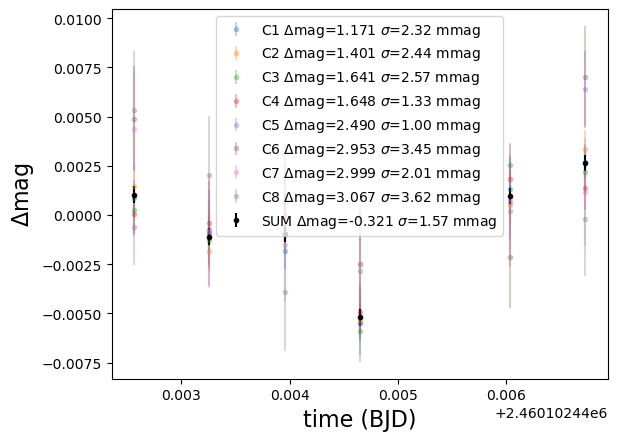

<Table length=6>
       TIME               x                  y          ...        magsum            magsum_err            diffmagsum      
     float64           float64            float64       ...       float64             float64               float64        
----------------- ------------------ ------------------ ... ------------------- -------------------- ----------------------
2460102.446036196 1011.5583993592952 373.41020514489236 ... -17.565992309893947 0.005362218014684386  0.0009580113038314408
2460102.446730652 1011.3083993592952 372.91020514489236 ... -17.559929497823088 0.005408245022828029   0.002643872874221742
2460102.444647272 1011.0583993592952 373.16020514489236 ...  -17.50391051324635 0.005711560210430767    -0.0051995238701803
2460102.442563881 1011.3083993592952 373.91020514489236 ... -17.539447852781226 0.005567577991411061  0.0010257892547809178
2460102.443258349 1011.3083993592952 373.41020514489236 ... -17.527938579261296 0.005600961311996393 -0.0010970142895398993
2460102.443952805 1011.3083993592952 373.16020514489236 ... -17.522863837575915 0.005609772454148034 -0.0009580113038314408

In [12]:
# Select target index
target = 0
# Select comparisons 
comps = [1, 2, 3, 4, 5, 6, 7, 8]

# plot light curve
s4plt.plot_light_curve(phot_ts_product,
                            target=target,
                            comps=comps,
                            nsig=10,
                            plot_coords=True,
                            plot_rawmags=True,
                            plot_sum=True,
                            plot_comps=True,
                            catalog_name=p['PHOT_REF_CATALOG_NAME'])

***
## `POLARIMETRIC` mode

## Select HD111579 data

In [13]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "hd111579" # HD111579 is a polarimetric standard

# create a list of science data 
pol_list = glob.glob("{}/{}".format(datadir,"*stdpol.fits"))

# set instrument mode to "POLAR"
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']

FORCE = False

## Reduce scientific exposures in `POLARIMETRY HALF-WAVE (L/2)` mode

To reduce scientific frames in polarimetric mode, we also use the same routine, ``s4pipelib.stack_and_reduce_sci_images``. This routine performs similar procedures as in photometric mode. Additionally, it matches and organizes the polarimetric pairs (dual beam) into two distinct catalogs. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into 'proc.fits' product FITS files.

In [14]:
# initial set up
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l2_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of half-wave files (L2)
pol_l2_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L2')

0 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000029_stdpol.fits
OBJECT files: 10
Loading science frames to memory ... 
gain: 3.36 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 10 : 20230606_s4c4_000029_stdpol.fits 
Calibrating science frame 2 of 10 : 20230606_s4c4_000045_stdpol.fits 
Calibrating science frame 3 of 10 : 20230606_s4c4_000035_stdpol.fits 
Calibrating science frame 4 of 10 : 20230606_s4c4_000025_stdpol.fits 
Calibrating science frame 5 of 10 : 20230606_s4c4_000049_stdpol.fits 
Calibrating science frame 6 of 10 : 20230606_s4c4_000039_stdpol.fits 
Calibrating science frame 7 of 10 : 20230606_s4c4_000033_stdpol.fits 
Calibrating science frame 8 of 10 : 20230606_s4c4_000043_stdpol.fits 
Calibrating science frame 9 of 10 : 20230606_s4c4_000023_stdpol.fits 
Calibrating science frame 10 of 10 : 20230606_s4c4_000041_stdpol.fits 


2024-04-18 16:24:04,778 astropop - INFO - Registering image 1 from 10  [register]
2024-04-18 16:24:04,781 astropop - INFO - Images are equal, skipping registering.  [register]


Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000029_stdpol.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000045_stdpol.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000035_stdpol.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000025_stdpol.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000049_stdpol.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000039_stdpol.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000033_stdpol.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000043_stdpol.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000023_stdpol.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000041_stdpol.fits


2024-04-18 16:24:04,994 astropop - INFO - Registering image 2 from 10  [register]
2024-04-18 16:24:05,114 astropop - INFO - Filling registered image with cval=37.57  [register]
2024-04-18 16:24:05,120 astropop - INFO - Registering image with: translation=[ 1.5  -1.75], rotation=0.00°  [register]
2024-04-18 16:24:05,401 astropop - INFO - Registering image 3 from 10  [register]
2024-04-18 16:24:05,510 astropop - INFO - Filling registered image with cval=36.14  [register]
2024-04-18 16:24:05,512 astropop - INFO - Registering image with: translation=[ 1.25 -0.5 ], rotation=0.00°  [register]
2024-04-18 16:24:05,854 astropop - INFO - Registering image 4 from 10  [register]
2024-04-18 16:24:06,045 astropop - INFO - Filling registered image with cval=35.26  [register]
2024-04-18 16:24:06,046 astropop - INFO - Registering image with: translation=[ 1.25 -0.  ], rotation=0.00°  [register]
2024-04-18 16:24:06,427 astropop - INFO - Registering image 5 from 10  [register]
2024-04-18 16:24:06,594 ast

Creating new catalog of detected sources:
Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()
Running photometry for multiple apertures:
Aperture radius of 6 pixels: 1 of 6 :
Aperture radius of 8 pixels: 2 of 6 :
Aperture radius of 10 pixels: 3 of 6 :
Aperture radius of 12 pixels: 4 of 6 :
Aperture radius of 14 pixels: 5 of 6 :
Aperture radius of 16 pixels: 6 of 6 :
The 16 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000029_stdpol_proc.fits
2 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000045_stdpol_proc.fits
3 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000035_stdpol_proc.fits
4 of 16 is reduced? False -> /Users

2024-04-18 16:24:21,579 astropop - INFO - Computing shift of image 1 from 16  [register]
2024-04-18 16:24:21,580 astropop - INFO - Computing shift of image 2 from 16  [register]
2024-04-18 16:24:21,653 astropop - INFO - Computing shift of image 3 from 16  [register]
2024-04-18 16:24:21,723 astropop - INFO - Computing shift of image 4 from 16  [register]
2024-04-18 16:24:21,772 astropop - INFO - Computing shift of image 5 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000029_stdpol.fits


2024-04-18 16:24:21,839 astropop - INFO - Computing shift of image 6 from 16  [register]
2024-04-18 16:24:21,958 astropop - INFO - Computing shift of image 7 from 16  [register]
2024-04-18 16:24:22,047 astropop - INFO - Computing shift of image 8 from 16  [register]
2024-04-18 16:24:22,133 astropop - INFO - Computing shift of image 9 from 16  [register]
2024-04-18 16:24:22,213 astropop - INFO - Computing shift of image 10 from 16  [register]
2024-04-18 16:24:22,297 astropop - INFO - Computing shift of image 11 from 16  [register]
2024-04-18 16:24:22,374 astropop - INFO - Computing shift of image 12 from 16  [register]
2024-04-18 16:24:22,436 astropop - INFO - Computing shift of image 13 from 16  [register]
2024-04-18 16:24:22,528 astropop - INFO - Computing shift of image 14 from 16  [register]
2024-04-18 16:24:22,608 astropop - INFO - Computing shift of image 15 from 16  [register]
2024-04-18 16:24:22,704 astropop - INFO - Computing shift of image 16 from 16  [register]


Processing file: 20230606_s4c4_000029_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=0.0 dy=0.0
Saving frame 1 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000029_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000029_stdpol_proc.fits
Processing file: 20230606_s4c4_000045_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=1.5 dy=-1.75
Saving frame 2 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000045_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000045_stdpol_proc.fits
Processing file: 20230606_s4c4_000035_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=1.25 dy=-0.5
Saving frame 3 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000035_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000035_stdpo

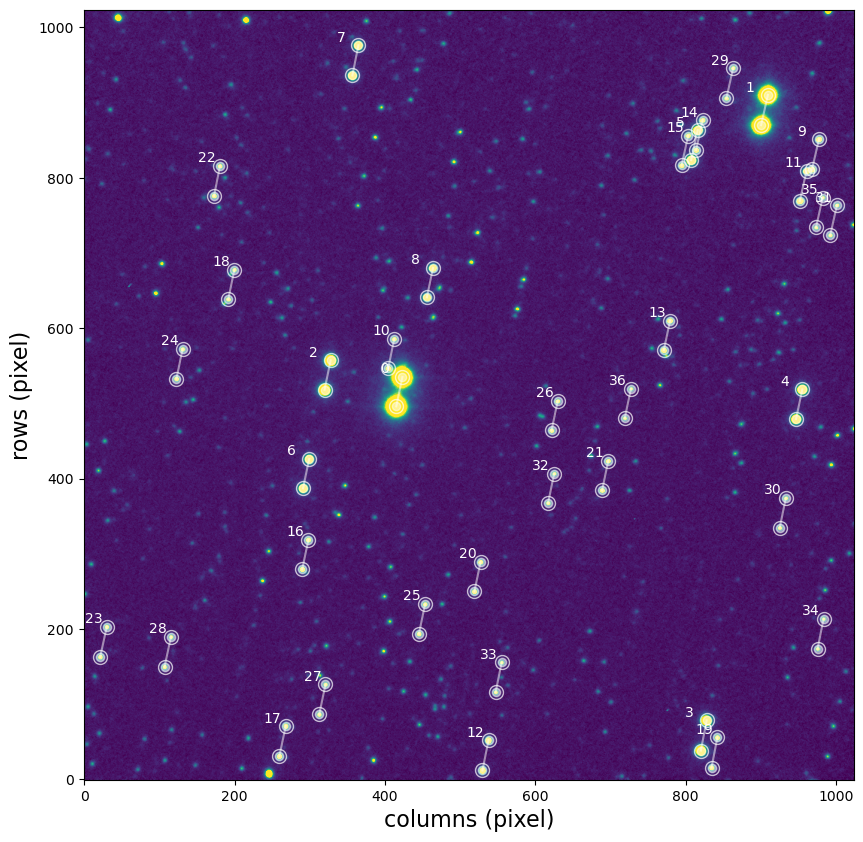

In [15]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l2_list,
                                          reducedir,
                                          stack_suffix=l2_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          verbose=True,
                                          plot=True) 

## Calculate `HALF-WAVE (L/2)` POLARIMETRY

The half-wave ($\lambda/2$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [16]:
# input reduced files list
red_pol_l2_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l2_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l2_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


Number of sources in catalog: 37
Number of apertures: 6  varying from 6.0 to 16.0 in steps of 2.0 pix
Calculating halfwave polarimetry for aperture 1 of 6
Calculating halfwave polarimetry for aperture 2 of 6
Calculating halfwave polarimetry for aperture 3 of 6
Calculating halfwave polarimetry for aperture 4 of 6
Calculating halfwave polarimetry for aperture 5 of 6
Calculating halfwave polarimetry for aperture 6 of 6
Saving output halfwave polarimetry product: /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606//20230606_s4c4_000019_stdpol_l2_polar.fits
Source index: i=0 
Source RA=192.77992113690317 Dec=-61.241375137700615 mag=-19.0837+-0.0002
Best aperture radius: 16.0 pixels
Polarization in Q: 0.0177+-0.0006
Polarization in U: 0.0465+-0.0006
Polarization in V: nan+-nan
Total linear polarization p: 0.0498+-0.0006
Angle of polarization theta: 34.6+-0.4
Free constant k: 1+-nan
Zero of polarization: 0.0+-0.0
RMS of zi residuals: 0.00080
Reduced chi-square (n=16.0, DOF=14.0): 7

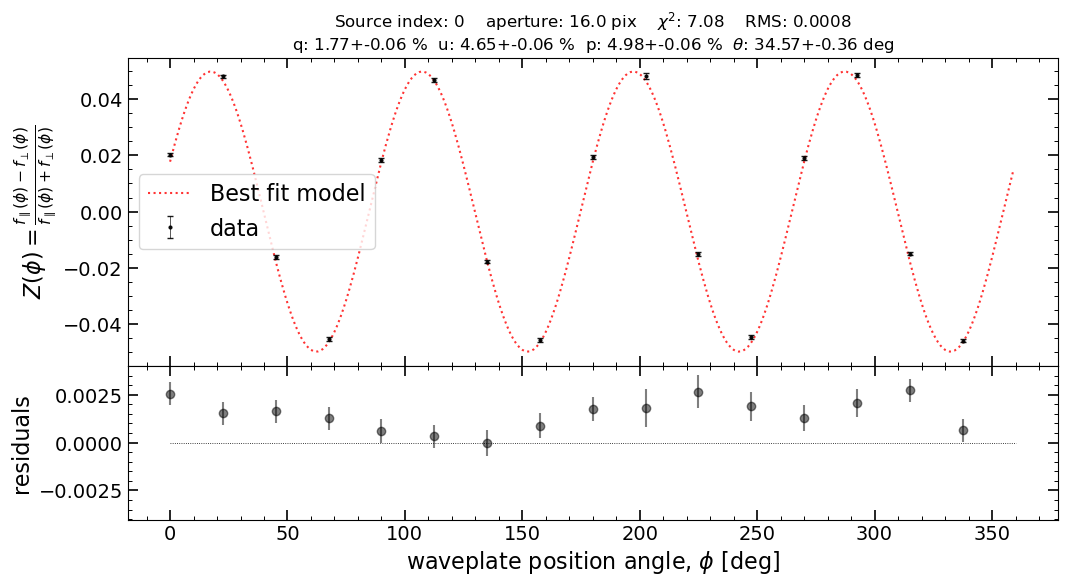

In [17]:
l2_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key = 'WPPOS',
                                                 wave_plate = 'halfwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = True,
                                                 fit_zero = False,
                                                 force = FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    
    l2_polar_products.append(polarproduct)

## Time series of `HALF-WAVE (L/2)` polarimetry data

In this section, we compile all selected polarimetric sequences into a time series product using the routine ``s4pipelib.polar_time_series``. However, for this particular example, since there is only one polarimetric sequence, the time series is not particularly relevant, as it contains only one point in time.

In [18]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)    

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l2_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

Packing time series data for polar file 1 of 1


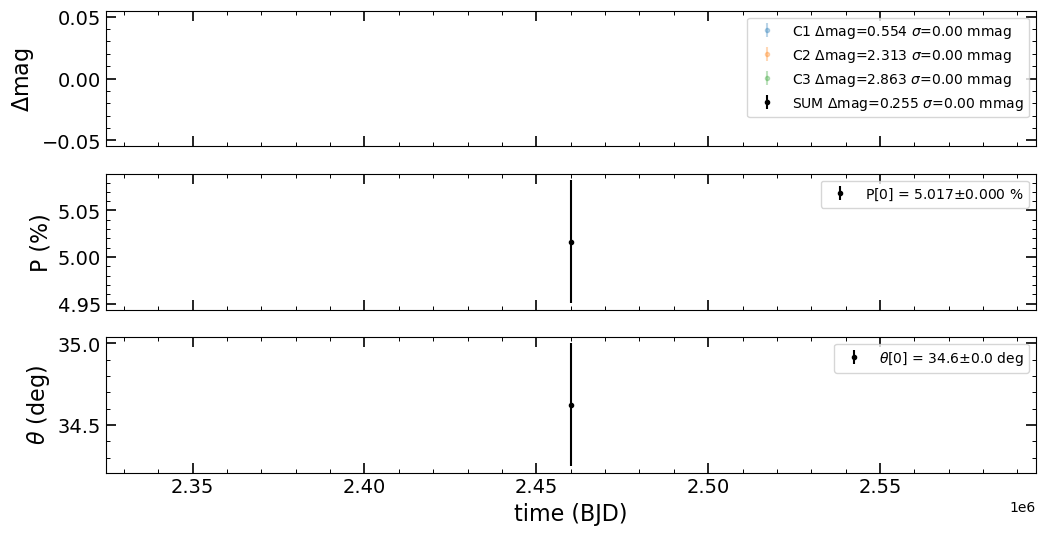

In [19]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)

## Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE (L/4)` mode

Now repeat all the reduction procedures above for the L/4 data.

In [20]:
# initial set up
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l4_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of quarter-wave files (L4)
pol_l4_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L4')

0 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000059_stdpol.fits
OBJECT files: 10
Loading science frames to memory ... 
gain: 3.36 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 10 : 20230606_s4c4_000059_stdpol.fits 
Calibrating science frame 2 of 10 : 20230606_s4c4_000077_stdpol.fits 
Calibrating science frame 3 of 10 : 20230606_s4c4_000055_stdpol.fits 
Calibrating science frame 4 of 10 : 20230606_s4c4_000067_stdpol.fits 
Calibrating science frame 5 of 10 : 20230606_s4c4_000071_stdpol.fits 
Calibrating science frame 6 of 10 : 20230606_s4c4_000061_stdpol.fits 
Calibrating science frame 7 of 10 : 20230606_s4c4_000053_stdpol.fits 
Calibrating science frame 8 of 10 : 20230606_s4c4_000073_stdpol.fits 
Calibrating science frame 9 of 10 : 20230606_s4c4_000063_stdpol.fits 
Calibrating science frame 10 of 10 : 20230606_s4c4_000051_stdpol.fits 


2024-04-18 16:24:49,285 astropop - INFO - Registering image 1 from 10  [register]
2024-04-18 16:24:49,287 astropop - INFO - Images are equal, skipping registering.  [register]
2024-04-18 16:24:49,367 astropop - INFO - Registering image 2 from 10  [register]


Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000059_stdpol.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000077_stdpol.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000055_stdpol.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000067_stdpol.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000071_stdpol.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000061_stdpol.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000053_stdpol.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000073_stdpol.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000063_stdpol.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000051_stdpol.fits


2024-04-18 16:24:49,472 astropop - INFO - Filling registered image with cval=37.05  [register]
2024-04-18 16:24:49,473 astropop - INFO - Registering image with: translation=[-0.25 -0.  ], rotation=0.00°  [register]
2024-04-18 16:24:49,625 astropop - INFO - Registering image 3 from 10  [register]
2024-04-18 16:24:49,709 astropop - INFO - Filling registered image with cval=37.16  [register]
2024-04-18 16:24:49,718 astropop - INFO - Registering image with: translation=[-1.25  0.25], rotation=0.00°  [register]
2024-04-18 16:24:49,833 astropop - INFO - Registering image 4 from 10  [register]
2024-04-18 16:24:49,924 astropop - INFO - Filling registered image with cval=36.72  [register]
2024-04-18 16:24:49,925 astropop - INFO - Registering image with: translation=[-0.5  -1.25], rotation=0.00°  [register]
2024-04-18 16:24:50,055 astropop - INFO - Registering image 5 from 10  [register]
2024-04-18 16:24:50,136 astropop - INFO - Filling registered image with cval=37.18  [register]
2024-04-18 16:

Creating new catalog of detected sources:
Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()
Running photometry for multiple apertures:
Aperture radius of 6 pixels: 1 of 6 :
Aperture radius of 8 pixels: 2 of 6 :
Aperture radius of 10 pixels: 3 of 6 :
Aperture radius of 12 pixels: 4 of 6 :
Aperture radius of 14 pixels: 5 of 6 :
Aperture radius of 16 pixels: 6 of 6 :
The 16 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000059_stdpol_proc.fits
2 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000077_stdpol_proc.fits
3 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000055_stdpol_proc.fits
4 of 16 is reduced? False -> /Users

2024-04-18 16:25:01,818 astropop - INFO - Computing shift of image 1 from 16  [register]
2024-04-18 16:25:01,818 astropop - INFO - Computing shift of image 2 from 16  [register]
2024-04-18 16:25:01,860 astropop - INFO - Computing shift of image 3 from 16  [register]
2024-04-18 16:25:01,963 astropop - INFO - Computing shift of image 4 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000059_stdpol.fits


2024-04-18 16:25:02,033 astropop - INFO - Computing shift of image 5 from 16  [register]
2024-04-18 16:25:02,103 astropop - INFO - Computing shift of image 6 from 16  [register]
2024-04-18 16:25:02,162 astropop - INFO - Computing shift of image 7 from 16  [register]
2024-04-18 16:25:02,227 astropop - INFO - Computing shift of image 8 from 16  [register]
2024-04-18 16:25:02,298 astropop - INFO - Computing shift of image 9 from 16  [register]
2024-04-18 16:25:02,373 astropop - INFO - Computing shift of image 10 from 16  [register]
2024-04-18 16:25:02,429 astropop - INFO - Computing shift of image 11 from 16  [register]
2024-04-18 16:25:02,492 astropop - INFO - Computing shift of image 12 from 16  [register]
2024-04-18 16:25:02,556 astropop - INFO - Computing shift of image 13 from 16  [register]
2024-04-18 16:25:02,627 astropop - INFO - Computing shift of image 14 from 16  [register]
2024-04-18 16:25:02,689 astropop - INFO - Computing shift of image 15 from 16  [register]
2024-04-18 16:2

Processing file: 20230606_s4c4_000059_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=0.0 dy=0.0
Saving frame 1 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000059_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000059_stdpol_proc.fits
Processing file: 20230606_s4c4_000077_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=-0.25 dy=-0.0
Saving frame 2 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000077_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000077_stdpol_proc.fits
Processing file: 20230606_s4c4_000055_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=-1.25 dy=0.25
Saving frame 3 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs4/20230606/20230606_s4c4_000055_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606/20230606_s4c4_000055_std

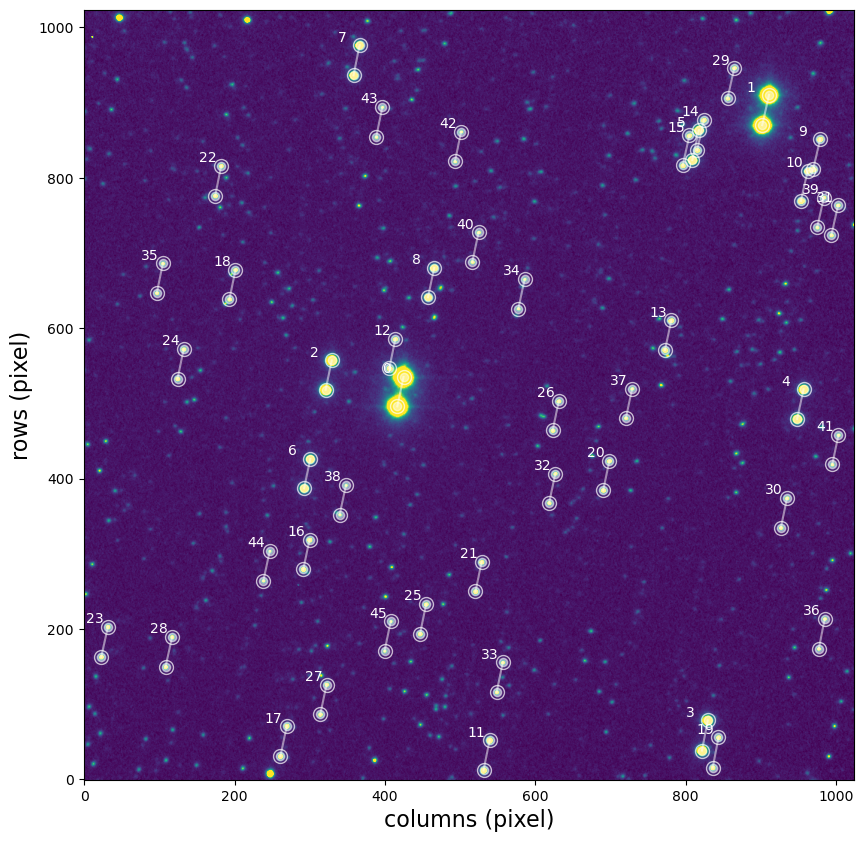

In [21]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l4_list,
                                          reducedir,
                                          stack_suffix=l4_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          verbose=True,
                                          plot=True) 

## Calculate `QUARTER-WAVE (L/4)` POLARIMETRY

The quarter-wave ($\lambda/4$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [22]:
# input reduced files list
red_pol_l4_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l4_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l4_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


2024-04-18 16:25:24,809 astropop - INFO - Normalization disabled.  [__init__]


Number of sources in catalog: 46
Number of apertures: 6  varying from 6.0 to 16.0 in steps of 2.0 pix
Calculating quarterwave polarimetry for aperture 1 of 6
Calculating quarterwave polarimetry for aperture 2 of 6
Calculating quarterwave polarimetry for aperture 3 of 6
Calculating quarterwave polarimetry for aperture 4 of 6
Calculating quarterwave polarimetry for aperture 5 of 6
Calculating quarterwave polarimetry for aperture 6 of 6
Saving output quarterwave polarimetry product: /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs4//20230606//20230606_s4c4_000051_stdpol_l4_polar.fits


2024-04-18 16:25:28,571 astropop - INFO - Normalization disabled.  [__init__]


Source index: i=0 
Source RA=192.7796282168844 Dec=-61.24137541964914 mag=-19.2580+-0.0002
Best aperture radius: 16.0 pixels
Polarization in Q: -0.062+-0.002
Polarization in U: -0+-9
Polarization in V: -0.000+-0.002
Total linear polarization p: 0.062+-0.002
Angle of polarization theta: 90.0+-0.8
Free constant k: 1+-nan
Zero of polarization: 0+-2000
RMS of zi residuals: 0.00304
Reduced chi-square (n=16.0, DOF=12.0): 50.71


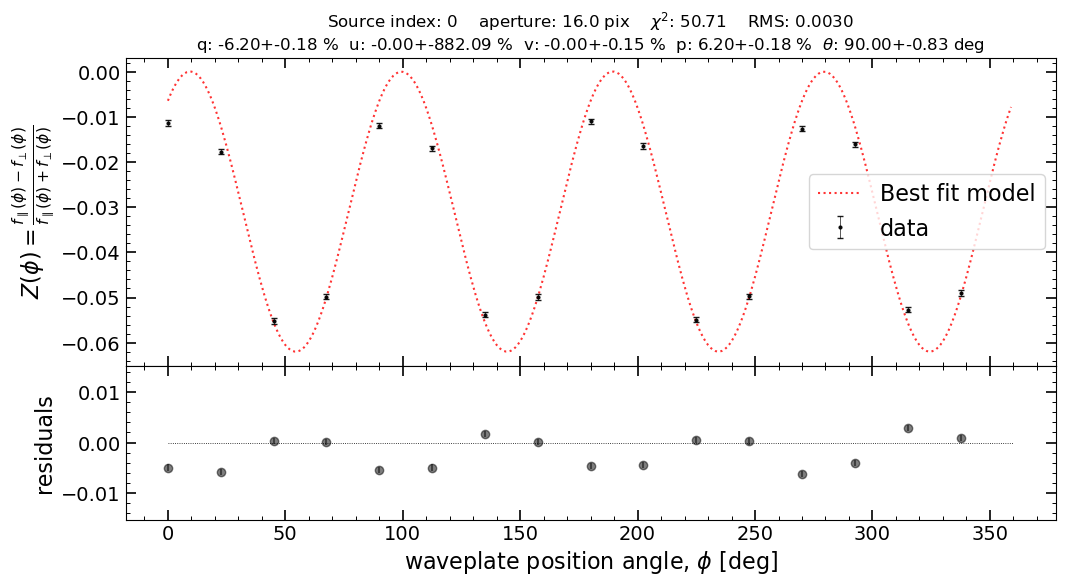

In [23]:
l4_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key='WPPOS',
                                                 wave_plate = 'quarterwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = False,
                                                 fit_zero = True,
                                                 force=FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    l4_polar_products.append(polarproduct)    

## Time series of `QUARTER-WAVE (L/4)` polarimetry data

In [24]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)   

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l4_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

Packing time series data for polar file 1 of 1


2024-04-18 16:25:28,854 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:28,876 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:28,897 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:28,923 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:28,944 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:28,964 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:28,985 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:29,009 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:29,031 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:29,054 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:29,077 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:29,099 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:25:29,120 astropop - INFO - Normalization disabled

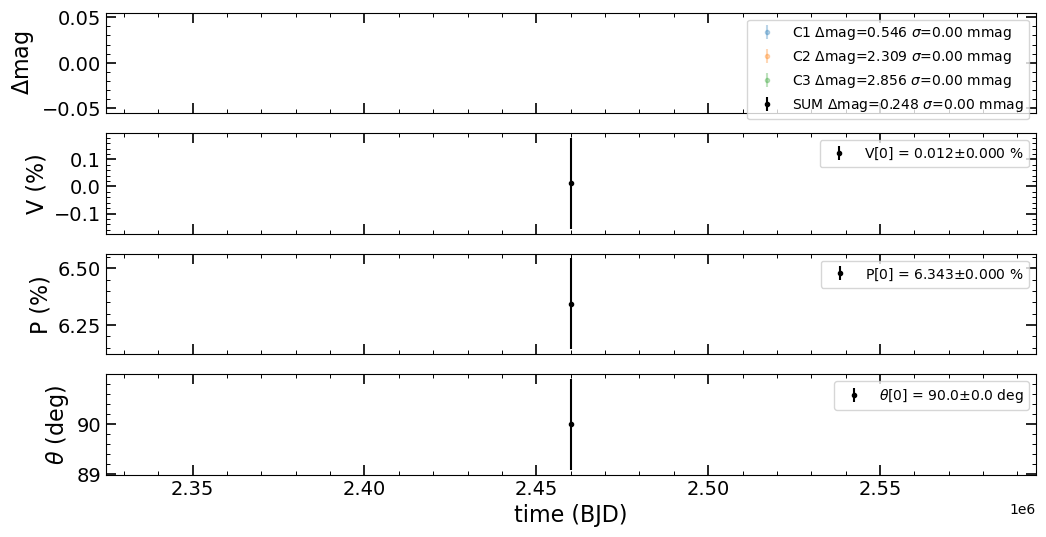

In [25]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)